In [6]:
import os
import random
import shutil
from pathlib import Path
from PIL import Image
import imagehash
from collections import defaultdict


# Paths
ORIG_DATASET = "original_dataset"
TARGET_DATASET = "splited_dataset"
SEED = 42

random.seed(SEED)

# Splits
SPLITS = {
    'train': 0.7,
    'val': 0.15,
    'test': 0.15
}

VALID_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp'}

# Pick images and hashes
hash_to_files = defaultdict(list)

print("Calculating hashes...")
for class_name in sorted(os.listdir(ORIG_DATASET)):
    class_dir = os.path.join(ORIG_DATASET, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.startswith('.'):
            continue
        ext = os.path.splitext(fname)[1].lower()
        if ext not in VALID_EXTENSIONS:
            continue
        fpath = os.path.join(class_dir, fname)
        try:
            img = Image.open(fpath).convert("RGB")
            h = imagehash.phash(img)
            hash_to_files[str(h)].append((fpath, class_name))
        except Exception as e:
            print(f"Error procesando {fpath}: {e}")

print("Total unique hashes:", len(hash_to_files))

# Mix hashes
hash_list = list(hash_to_files.items())
random.shuffle(hash_list)

# Create folders
for split in SPLITS:
    for class_name in os.listdir(ORIG_DATASET):
        Path(os.path.join(TARGET_DATASET, split, class_name)).mkdir(parents=True, exist_ok=True)

# Counters
class_counts = defaultdict(lambda: {'train':0, 'val':0, 'test':0})
total_images_per_class = defaultdict(int)

for h, files in hash_list:
    classes_in_hash = set([c for _, c in files])
    for c in classes_in_hash:
        total_images_per_class[c] += sum(1 for f in files if f[1]==c)

def assign_split(class_name):
    counts = class_counts[class_name]
    total = total_images_per_class[class_name]
    train_target = SPLITS['train'] * total
    val_target = SPLITS['val'] * total
    test_target = SPLITS['test'] * total
    if counts['train'] < train_target:
        return 'train'
    elif counts['val'] < val_target:
        return 'val'
    else:
        return 'test'

# Distribute
for h, files in hash_list:
    files_by_class = defaultdict(list)
    for fpath, class_name in files:
        files_by_class[class_name].append(fpath)
    for class_name, flist in files_by_class.items():
        split = assign_split(class_name)
        for src in flist:
            dest = os.path.join(TARGET_DATASET, split, class_name, os.path.basename(src))
            shutil.copy2(src, dest)
            class_counts[class_name][split] +=1

# Overview
print("\n=== Overview ===")
for class_name in sorted(total_images_per_class):
    counts = class_counts[class_name]
    total = sum(counts.values())
    print(f"Clase '{class_name}': Total={total}")
    for split in SPLITS:
        pct = 100 * counts[split]/total
        print(f"  {split}: {counts[split]} imágenes ({pct:.1f}%)")


Calculating hashes...
Total unique hashes: 2986

=== Overview ===
Clase 'esophagitis': Total=1000
  train: 700 imágenes (70.0%)
  val: 150 imágenes (15.0%)
  test: 150 imágenes (15.0%)
Clase 'polyps': Total=1000
  train: 700 imágenes (70.0%)
  val: 150 imágenes (15.0%)
  test: 150 imágenes (15.0%)
Clase 'ulcerative-colitis': Total=1000
  train: 700 imágenes (70.0%)
  val: 150 imágenes (15.0%)
  test: 150 imágenes (15.0%)


## MobileNet with weights and Fine Tuning

In [30]:
import cv2
import numpy as np

def image_res(imagen, brillo_min=40, **kwargs):
    """
    Cleans the endoscopic image by removing the green box (ScopeGuide),
    cropping the bright useful region if applicable, and masking any green
    box by filling it with the average color (excluding green regions).
    """

    # Convert to LAB to detect brightness
    imagen_lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    l_channel, _, _ = cv2.split(imagen_lab)

    # Brightness threshold
    _, mask = cv2.threshold(l_channel, brillo_min, 255, cv2.THRESH_BINARY)

    # Erosion + dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Search for contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)
        if w * h < 0.95 * imagen.shape[0] * imagen.shape[1]:
            margen = 10
            x = max(x - margen, 0)
            y = max(y - margen, 0)
            x2 = min(x + w + 2 * margen, imagen.shape[1])
            y2 = min(y + h + 2 * margen, imagen.shape[0])
            imagen = imagen[y:y2, x:x2]
            mask = mask[y:y2, x:x2]

    # Convert to HSV
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Green range
    verde_bajo = np.array([35, 100, 100])
    verde_alto = np.array([85, 255, 255])

    mask_verde = cv2.inRange(hsv, verde_bajo, verde_alto)

    # Morphology to join disperse pixels
    kernel_verde = np.ones((15, 15), np.uint8)
    mask_verde = cv2.morphologyEx(mask_verde, cv2.MORPH_CLOSE, kernel_verde)
    mask_verde = cv2.dilate(mask_verde, kernel_verde, iterations=1)

    n_pixels_verdes = cv2.countNonZero(mask_verde)

    # Prepare mask to exclude green
    if cv2.countNonZero(mask) > 0:
        # Combine brightness mask and NOT green mask
        mask_no_verde = cv2.bitwise_and(mask, cv2.bitwise_not(mask_verde))
        if cv2.countNonZero(mask_no_verde) > 0:
            mean_color = cv2.mean(imagen, mask=mask_no_verde)[:3]
        else:
            # If everything is green, fallback to no-green over whole image
            mask_all_no_verde = cv2.bitwise_not(mask_verde)
            mean_color = cv2.mean(imagen, mask=mask_all_no_verde)[:3]
    else:
        # No brightness mask, use entire image excluding green
        mask_all_no_verde = cv2.bitwise_not(mask_verde)
        mean_color = cv2.mean(imagen, mask=mask_all_no_verde)[:3]

    mean_color = np.array(mean_color, dtype=np.uint8)

    if n_pixels_verdes > 0:
        relleno = np.full(imagen.shape, mean_color, dtype=np.uint8)
        mask_verde_3c = cv2.merge([mask_verde]*3)
        imagen_resultado = np.where(mask_verde_3c > 0, relleno, imagen)
        return imagen_resultado

    return imagen


In [38]:
from tensorflow.keras.utils import Sequence
import numpy as np


class AlbumentationsDataGenerator(Sequence):
    def __init__(self, image_paths, labels, transform, batch_size=32, num_classes=3, shuffle=True, target_size=(224,224)):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            img = cv2.imread(self.image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = self.transform(image=img)
            img = augmented['image'].astype(np.float32) / 255.0                   
            batch_images.append(img)
            batch_labels.append(self.labels[i])
        batch_images = np.array(batch_images)
        batch_labels = np.eye(self.num_classes)[batch_labels]
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

            batch_images.append(img)
            batch_labels.append(self.labels[i])
        batch_images = np.array(batch_images)
        batch_labels = np.eye(self.num_classes)[batch_labels]
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [2]:
import glob

class_indices = {'esophagitis':0, 'polyps':1, 'ulcerative-colitis':2}

train_image_paths = []
train_labels = []

for class_name, idx in class_indices.items():
    files = glob.glob(f"splited_dataset/train/{class_name}/*")
    train_image_paths.extend(files)
    train_labels.extend([idx]*len(files))

# Second version of the model

## Using image_res

In [40]:
import tensorflow as tf
import datetime
import cv2
import os
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# ===== WandB imports =====
import wandb
from wandb.integration.keras import WandbCallback

wandb.init(project="kvasir-classes")
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

wandb.init(
    project="kvasir-classes",
    name="mobilenetv2-fineTun_albumentation5",
    config={
        "epochs": 30,
        "batch_size": 32,
        "architecture": "MobileNetV2",
        "image_size": 224
    }
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Albumentations
train_transform = A.Compose([
    A.Lambda(image=image_res, p=1.0),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.RandomGamma(gamma_limit=(90,110), p=0.3),
    A.Resize(224,224)
])


val_transform = A.Compose([
    A.Resize(224,224)
])

train_gen = AlbumentationsDataGenerator(
    image_paths=train_image_paths,
    labels=train_labels,
    transform=train_transform,
    batch_size=32,
    num_classes=3,
    shuffle=True
)

# Validación
val_image_paths = []
val_labels = []
for class_name, idx in class_indices.items():
    files = glob.glob(f"dataset/val/{class_name}/*")
    val_image_paths.extend(files)
    val_labels.extend([idx]*len(files))

val_gen = AlbumentationsDataGenerator(
    image_paths=val_image_paths,
    labels=val_labels,
    transform=val_transform,
    batch_size=32,
    num_classes=3,
    shuffle=False
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Load pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # Regularization L2
    ),
    layers.Dropout(0.3),  # Dropout para shrinkage
    layers.Dense(3, activation='softmax')
])
# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train frozen
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tensorboard_callback,
        early_stop,
        WandbCallback(save_model=False, save_graph=False)
    ]
)

# Fine-tune
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[
        tensorboard_callback,
        early_stop,
        WandbCallback(save_model=False, save_graph=False)
    ]
)

# Save
model.save("model_mobilenetV2_albumentation5.keras")

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


C:\Users\valer\AppData\Roaming\Python\Python310\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\valer\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8272 - loss: 0.4221 - val_accuracy: 0.9444 - val_loss: 0.1790
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9481 - loss: 0.1738 - val_accuracy: 0.9644 - val_loss: 0.1398
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9524 - loss: 0.1783 - val_accuracy: 0.9733 - val_loss: 0.1141
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9590 - loss: 0.1457 - val_accuracy: 0.9622 - val_loss: 0.1298
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9657 - loss: 0.1290 - val_accuracy: 0.9644 - val_loss: 0.1100
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.9620 - loss: 0.1312 - val_accuracy: 0.9267 - val_loss: 0.2350
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9509 - loss: 0.1503 - val_accuracy: 0.9756 - val_loss: 0.1064
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9722 - loss: 0.1076 - val_accuracy: 0.9578 - v

In [9]:
test_image_paths = []
test_labels = []

for class_name, idx in class_indices.items():
    files = glob.glob(f"splited_dataset/test/{class_name}/*")
    test_image_paths.extend(files)
    test_labels.extend([idx]*len(files))

In [42]:
test_transform = A.Compose([
    A.Lambda(image=image_res, p=1.0),
    A.Resize(224,224)
])

In [44]:
test_gen = AlbumentationsDataGenerator(
    image_paths=test_image_paths,
    labels=test_labels,
    transform=test_transform,
    batch_size=32,
    num_classes=3,
    shuffle=False
)

model = tf.keras.models.load_model("model_mobilenetV2_albumentation5.keras")

loss, acc = model.evaluate(test_gen, verbose=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9476 - loss: 0.2217


15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

====== Metrics ======
Accuracy: 0.9356
Precision (macro): 0.9439
Recall (macro): 0.9356
F1 Score (macro): 0.9347
Specificity per class:
  Clase 0: 0.9900
  Clase 1: 1.0000
  Clase 2: 0.9133

======Confusion matrix========:


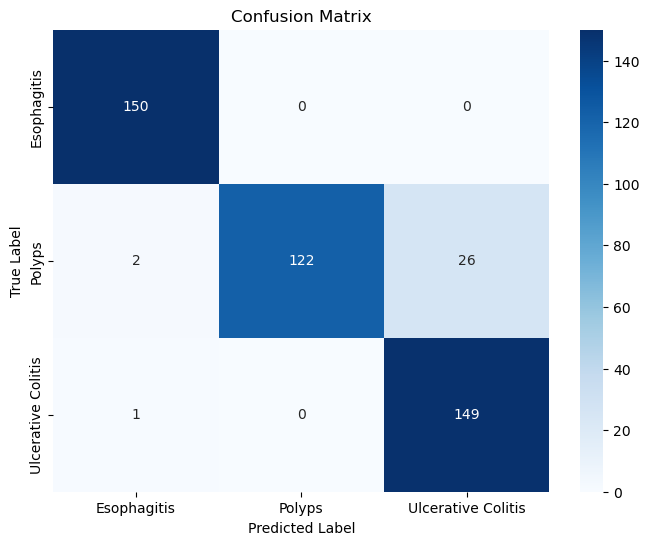

In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

generator = test_gen  # val_gen

y_true = np.array(generator.labels)


y_pred_probs = model.predict(generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy global
acc = accuracy_score(y_true, y_pred)

# Average Macro Precision 
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

# Recall Average Macro
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

# F1 score Average Macro
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Esophagitis', 'Polyps', 'Ulcerative Colitis']


# Specificity per class:
# Specificity = TN / (TN + FP)
specificity_per_class = []
for i in range(cm.shape[0]):
    TN = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    FP = cm[:,i].sum() - cm[i,i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity_per_class.append(specificity)

# Results
print("\n====== Metrics ======")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print("Specificity per class:")
for idx, s in enumerate(specificity_per_class):
    print(f"  Clase {idx}: {s:.4f}")
print("\n======Confusion matrix========:")
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Another test. ont his one I corrected the splited val dataset

In [54]:
wandb.init(
    project="kvasir-classes",
    name="mobilenetv2-fineTun_albumentation8",
    config={
        "epochs": 30,
        "batch_size": 32,
        "architecture": "MobileNetV2",
        "image_size": 224
    }
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Albumentations
train_transform = A.Compose([
    A.Lambda(image=image_res, p=1.0),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.RandomGamma(gamma_limit=(90,110), p=0.3),
    A.Resize(224,224)
])


val_transform = A.Compose([
    A.Lambda(image=image_res, p=1.0),
    A.Resize(224,224)
])

train_gen = AlbumentationsDataGenerator(
    image_paths=train_image_paths,
    labels=train_labels,
    transform=train_transform,
    batch_size=32,
    num_classes=3,
    shuffle=True
)

# Validación
val_image_paths = []
val_labels = []
for class_name, idx in class_indices.items():
    files = glob.glob(f"splited_dataset/val/{class_name}/*")
    val_image_paths.extend(files)
    val_labels.extend([idx]*len(files))

val_gen = AlbumentationsDataGenerator(
    image_paths=val_image_paths,
    labels=val_labels,
    transform=val_transform,
    batch_size=32,
    num_classes=3,
    shuffle=False
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Load pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # Regularization L2
    ),
    layers.Dropout(0.3),  # Dropout para shrinkage
    layers.Dense(3, activation='softmax')
])
# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train frozen
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tensorboard_callback,
        early_stop,
        WandbCallback(save_model=False, save_graph=False)
    ]
)

# Fine-tune
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[
        tensorboard_callback,
        early_stop,
        WandbCallback(save_model=False, save_graph=False)
    ]
)

# Save
model.save("model_mobilenetV2_albumentation8.keras")

accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.9119
best_epoch,0
best_val_loss,0.13506
epoch,0
loss,0.27003
val_accuracy,0.96889


C:\Users\valer\AppData\Roaming\Python\Python310\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\valer\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8129 - loss: 0.4762 - val_accuracy: 0.9533 - val_loss: 0.1730
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.9376 - loss: 0.1987 - val_accuracy: 0.9333 - val_loss: 0.1888
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.9604 - loss: 0.1692 - val_accuracy: 0.9822 - val_loss: 0.0950
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.9579 - loss: 0.1475 - val_accuracy: 0.9844 - val_loss: 0.0987
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.9619 - loss: 0.1352 - val_accuracy: 0.9822 - val_loss: 0.1164
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.9629 - loss: 0.1484 - val_accuracy: 0.9822 - val_loss: 0.1027
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 656s 9s/step - accuracy: 0.6873 - loss: 0.9376 - val_accuracy: 0.9756 - val_loss: 0.1277
Epoch 2/20
66/66 ━━━━━━━━━━━